# Predictive Modeling for Airline Booking using Random Forest

This Jupyter Notebook demonstrates a machine learning workflow to predict customer booking completion using a Random Forest Classifier. The analysis includes the following key steps:

Data Preprocessing: Cleaning and preparing a dataset with features such as sales channel, trip type, customer preferences, and flight details.
Feature Engineering: Creating new features to enhance predictive power, including the total number of extra services requested.

Model Training: Building and training a Random Forest Classifier to predict the likelihood of booking completion, with a focus on handling class imbalance using class_weight='balanced'.

Model Evaluation: Evaluating the model’s performance using accuracy, confusion matrix, precision, recall, and F1-score. 

Hyperparameter Tuning: Using RandomizedSearchCV to optimize model parameters for better performance.
The notebook demonstrates how to preprocess data, engineer meaningful features, train predictive models, and evaluate performance. This project is an example of how data science can be applied to understand and predict customer behavior in the airline industry.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
# Correlation between each feature and the target variable
correlation_with_target = df.corr()['booking_complete'].sort_values(ascending=False)
print(correlation_with_target)

booking_complete         1.000000
wants_extra_baggage      0.068139
wants_preferred_seat     0.050116
wants_in_flight_meals    0.026511
num_passengers           0.024116
flight_hour              0.007127
flight_day              -0.006986
purchase_lead           -0.022131
length_of_stay          -0.042408
flight_duration         -0.106266
Name: booking_complete, dtype: float64


C:\Users\Prajakta\AppData\Local\Temp\ipykernel_36808\660991167.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = df.corr()['booking_complete'].sort_values(ascending=False)


In [9]:
# Create the new feature by summing up the three binary columns
df['extra_services_requested'] = (
    df['wants_extra_baggage'] + 
    df['wants_preferred_seat'] + 
    df['wants_in_flight_meals']
)

# Drop the original columns as they're now combined into 'extra_services_requested'
df.drop(columns=['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals'], inplace=True)

# Display the first few rows to verify
print(df.head())


   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour  flight_day   route booking_origin  flight_duration  \
0            7           6  AKLDEL    New Zealand             5.52   
1            3           6  AKLDEL    New Zealand             5.52   
2           17           3  AKLDEL          India             5.52   
3            4           6  AKLDEL    New Zealand             5.52   
4           15           3  AKLDEL          India             5.52   

   booking_complete  extra_services_requested  
0                 0                         1  
1                 0 

In [10]:
print(df['sales_channel'].unique())
print(df['trip_type'].unique())
print(df['route'].unique())
print(df['booking_origin'].unique())

['Internet' 'Mobile']
['RoundTrip' 'CircleTrip' 'OneWay']
['AKLDEL' 'AKLHGH' 'AKLHND' 'AKLICN' 'AKLKIX' 'AKLKTM' 'AKLKUL' 'AKLMRU'
 'AKLPEK' 'AKLPVG' 'AKLTPE' 'AORICN' 'AORKIX' 'AORKTM' 'AORMEL' 'BBIMEL'
 'BBIOOL' 'BBIPER' 'BBISYD' 'BDOCTS' 'BDOCTU' 'BDOHGH' 'BDOICN' 'BDOIKA'
 'BDOKIX' 'BDOMEL' 'BDOOOL' 'BDOPEK' 'BDOPER' 'BDOPUS' 'BDOPVG' 'BDOSYD'
 'BDOTPE' 'BDOXIY' 'BKICKG' 'BKICTS' 'BKICTU' 'BKIHND' 'BKIICN' 'BKIKIX'
 'BKIKTM' 'BKIMEL' 'BKIMRU' 'BKIOOL' 'BKIPEK' 'BKIPER' 'BKIPUS' 'BKIPVG'
 'BKISYD' 'BKIXIY' 'BLRICN' 'BLRMEL' 'BLRPER' 'BLRSYD' 'BOMMEL' 'BOMOOL'
 'BOMPER' 'BOMSYD' 'BTJJED' 'BTUICN' 'BTUPER' 'BTUSYD' 'BTUWUH' 'BWNCKG'
 'BWNDEL' 'BWNHGH' 'BWNIKA' 'BWNKTM' 'BWNMEL' 'BWNOOL' 'BWNPER' 'BWNSYD'
 'BWNTPE' 'CANDEL' 'CANIKA' 'CANMEL' 'CANMRU' 'CANOOL' 'CANPER' 'CANSYD'
 'CCUMEL' 'CCUMRU' 'CCUOOL' 'CCUPER' 'CCUSYD' 'CCUTPE' 'CEBMEL' 'CEBOOL'
 'CEBPER' 'CEBSYD' 'CGKCKG' 'CGKCTS' 'CGKCTU' 'CGKDEL' 'CGKHGH' 'CGKHND'
 'CGKICN' 'CGKIKA' 'CGKJED' 'CGKKIX' 'CGKKTM' 'CGKMEL' 'CGKMRU' 'C

In [11]:
df.drop(columns=['route','booking_origin'], inplace=True)

In [12]:
mapping1= {
    "Internet": 0,
    "Mobile": 1,}

df["sales_channel"] = df["sales_channel"].map(mapping1)




In [13]:
mapping2= {
    "RoundTrip": 0,
    "CircleTrip": 1,
    "OneWay": 2,
}

df["trip_type"] = df["trip_type"].map(mapping2)

In [14]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,booking_complete,extra_services_requested
0,2,0,0,262,19,7,6,5.52,0,1
1,1,0,0,112,20,3,6,5.52,0,0
2,2,0,0,243,22,17,3,5.52,0,2
3,1,0,0,96,31,4,6,5.52,0,1
4,2,0,0,68,22,15,3,5.52,0,2


In [15]:
# Correlation between each feature and the target variable
correlation_with_target = df.corr()['booking_complete'].sort_values(ascending=False)
print(correlation_with_target)

booking_complete            1.000000
extra_services_requested    0.067828
num_passengers              0.024116
flight_hour                 0.007127
flight_day                 -0.006986
purchase_lead              -0.022131
trip_type                  -0.027215
sales_channel              -0.041060
length_of_stay             -0.042408
flight_duration            -0.106266
Name: booking_complete, dtype: float64


In [16]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Series([], dtype: int64)


In [17]:
# Separate the features (X) and the target (Y)
X = df.drop(columns=['booking_complete'])
Y = df['booking_complete']

# Display the shapes to verify the split
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


Shape of X: (50000, 9)
Shape of Y: (50000,)


In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the shapes to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)


Shape of X_train: (40000, 9)
Shape of X_test: (10000, 9)
Shape of Y_train: (40000,)
Shape of Y_test: (10000,)


In [20]:

# Initialize the Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced',random_state=42)

# Train the model on the training data
rf_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
class_report = classification_report(Y_test, Y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.8494
Confusion Matrix:
 [[8407  113]
 [1393   87]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.43      0.06      0.10      1480

    accuracy                           0.85     10000
   macro avg       0.65      0.52      0.51     10000
weighted avg       0.80      0.85      0.80     10000



In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, Y, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-Validation Accuracy Scores: [0.8504 0.828  0.7457 0.385  0.4415]
Mean CV Accuracy: 0.65012


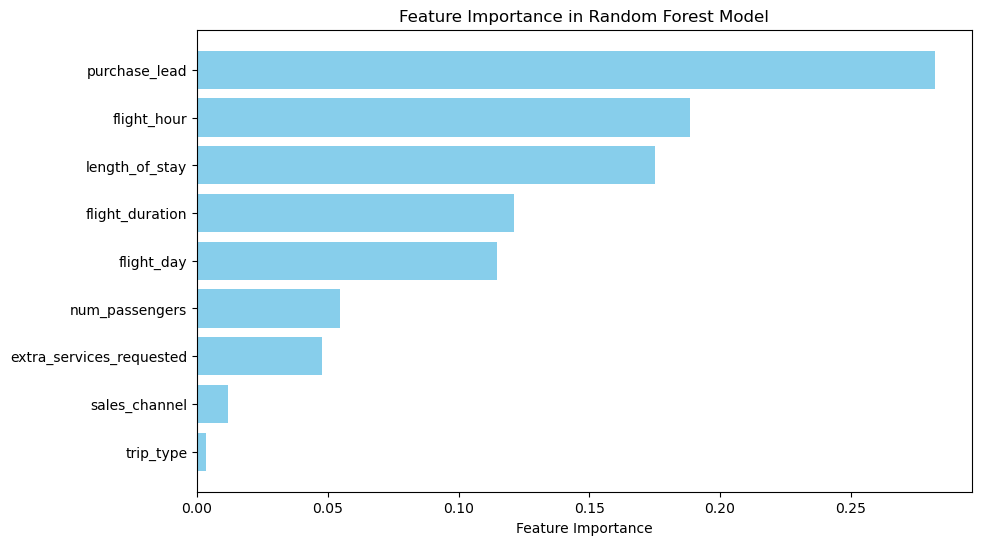

In [22]:
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  # Invert to show highest importance at the top
plt.show()
